# 10. Approximate Inference

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from prml.rv import VariationalGaussianMixture
from prml.features import PolynomialFeatures
from prml.linear import (
    VariationalLinearRegressor,
    VariationalLogisticRegressor
)

np.random.seed(1234)

## 10.2 Illustration: Variational Mixture of Gaussians

In [2]:
x1 = np.random.normal(size=(100, 2))
x1 += np.array([-5, -5])
x2 = np.random.normal(size=(100, 2))
x2 += np.array([5, -5])
x3 = np.random.normal(size=(100, 2))
x3 += np.array([0, 5])
x_train = np.vstack((x1, x2, x3))

x0, x1 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
x = np.array([x0, x1]).reshape(2, -1).T

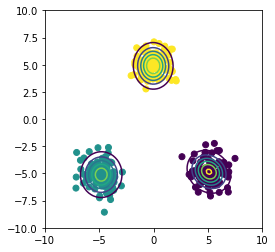

In [3]:
vgmm = VariationalGaussianMixture(n_components=6)
vgmm.fit(x_train)

plt.scatter(x_train[:, 0], x_train[:, 1], c=vgmm.classify(x_train))
plt.contour(x0, x1, vgmm.pdf(x).reshape(100, 100))
plt.xlim(-10, 10, 100)
plt.ylim(-10, 10, 100)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [4]:
vgmm = VariationalGaussianMixture(n_components=6)
vgmm._init_params(x_train)
params = np.hstack([param.flatten() for param in vgmm.get_params()])
fig = plt.figure()
colors = np.array(["r", "orange", "y", "g", "b", "purple"])
frames = []
for _ in range(100):
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.gca().set_aspect('equal', adjustable='box')
    r = vgmm._variational_expectation(x_train)
    imgs = [plt.scatter(x_train[:, 0], x_train[:, 1], c=colors[np.argmax(r, -1)])]
    for i in range(vgmm.n_components):
        if vgmm.component_size[i] > 1:
            imgs.append(plt.scatter(vgmm.mu[i, 0], vgmm.mu[i, 1], 100, colors[i], "X", lw=2, edgecolors="white"))
    frames.append(imgs)
    vgmm._variational_maximization(x_train, r)
    new_params = np.hstack([param.flatten() for param in vgmm.get_params()])
    if np.allclose(new_params, params):
        break
    else:
        params = np.copy(new_params)
plt.close()
plt.rcParams['animation.html'] = 'html5'
anim = animation.ArtistAnimation(fig, frames)
anim

## 10.3 Variational Linear Regression

In [5]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def cubic(x):
    return x * (x - 5) * (x + 5)

x_train, y_train = create_toy_data(cubic, 10, 10., [-5, 5])
x = np.linspace(-5, 5, 100)
y = cubic(x)

feature = PolynomialFeatures(degree=3)
X_train = feature.transform(x_train)
X = feature.transform(x)

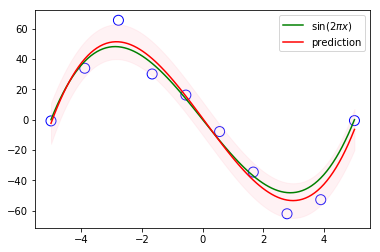

In [6]:
vlr = VariationalLinearRegressor(beta=0.01)
vlr.fit(X_train, y_train)
y_mean, y_std = vlr.predict(X, return_std=True)
plt.scatter(x_train, y_train, s=100, facecolor="none", edgecolor="b")
plt.plot(x, y, c="g", label="$\sin(2\pi x)$")
plt.plot(x, y_mean, c="r", label="prediction") 
plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color="pink")
plt.legend()
plt.show()

## 10.6 Variational Logistic Regression

In [7]:
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1, 2) - 3.
    x1 = np.random.normal(size=50).reshape(-1, 2) + 3.
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)
x_train, y_train = create_toy_data()
x0, x1 = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
x = np.array([x0, x1]).reshape(2, -1).T
feature = PolynomialFeatures(degree=1)
X_train = feature.transform(x_train)
X = feature.transform(x)

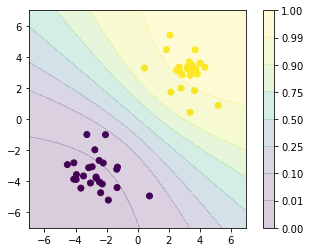

In [8]:
vlr = VariationalLogisticRegressor()
vlr.fit(X_train, y_train)
y = vlr.proba(X).reshape(100, 100)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y, np.array([0., 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1.]), alpha=0.2)
plt.colorbar()
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()